In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
import math
import os
import time
import pdb
import numbers

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ
from anytree import Node, PreOrderIter
from anytree.search import findall_by_attr
from anytree.render import RenderTree

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [16]:
import tqdm

# Two Room Setting for Option Discovery

In [2]:
twoRooms_grid = two_rooms_grid(room_width=10, room_height=10, doorway_pos=5, doorway_height=2, goal_height=0)

In [3]:
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

..........x.........1
..........x..........
..........x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


## Reseting density
We have modified the gridworld code so that to specify a specific resetting density (here we want x0 to be in the left hand room)

In [4]:
# reset density : uniform in left hand side
reset_density = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
for i in range(reset_density.shape[0]):
    for j in range(reset_density.shape[1]):
        if twoRooms_grid[i][j] != 'x' and 'x' in twoRooms_grid[i][j:]:
            reset_density[i][j] = 1
reset_density /= reset_density.sum()

In [5]:
twoRooms = GridWorld(gamma=0.9, grid=twoRooms_grid, reset_density=reset_density)

## Testing the reseting density
The 'o' marks the starting point, it should always be in the left hand side.

In [6]:
x0 = twoRooms.reset()
i,j = twoRooms.state2coord[x0]
twoRooms_grid = two_rooms_grid(room_width=10, room_height=10, doorway_pos=5, doorway_height=2, goal_height=0)
twoRooms_grid[i][j] = 'o'
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

o.........x.........1
..........x..........
..........x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


## 40 episodes Q-Learning

In [7]:
P = PolicyLearning(ind=0, GridWorld=twoRooms, max_iter=40)
record_trajectory = []
P.run(record_trajectory = record_trajectory)

In [8]:
record_trajectory

[[(188, 0, 0.0),
  (189, 0, 0.0),
  (190, 3, 0.0),
  (170, 0, 0.0),
  (171, 1, 0.0),
  (191, 2, 0.0),
  (190, 0, 0.0),
  (191, 3, 0.0),
  (171, 1, 0.0),
  (191, 2, 0.0),
  (190, 2, 0.0),
  (189, 2, 0.0),
  (188, 0, 0.0),
  (189, 0, 0.0),
  (188, 0, 0.0),
  (189, 0, 0.0),
  (190, 0, 0.0),
  (191, 2, 0.0),
  (190, 0, 0.0),
  (191, 2, 0.0),
  (190, 0, 0.0),
  (191, 2, 0.0),
  (190, 0, 0.0),
  (191, 2, 0.0),
  (190, 0, 0.0),
  (191, 2, 0.0),
  (190, 2, 0.0),
  (189, 3, 0.0),
  (169, 0, 0.0),
  (170, 2, 0.0),
  (169, 2, 0.0),
  (168, 0, 0.0),
  (169, 0, 0.0),
  (170, 0, 0.0),
  (171, 1, 0.0),
  (151, 1, 0.0),
  (131, 1, 0.0),
  (110, 0, 0.0),
  (111, 0, 0.0),
  (112, 0, 0.0),
  (111, 2, 0.0),
  (110, 2, 0.0),
  (109, 0, 0.0),
  (110, 3, 0.0),
  (89, 0, 0.0),
  (90, 0, 0.0),
  (91, 3, 0.0),
  (70, 0, 0.0),
  (71, 0, 0.0),
  (72, 3, 0.0),
  (93, 0, 0.0),
  (92, 0, 0.0),
  (93, 2, 0.0),
  (92, 1, 0.0),
  (113, 0, 0.0),
  (114, 0, 0.0),
  (115, 0, 0.0),
  (116, 0, 0.0),
  (117, 3, 0.0),
  (96, 

## Compute the Diverse Density of state s

In [9]:
def gaussian_dist(center,B):
    center_np = np.array(twoRooms.state2coord[center])
    B_np = np.array(twoRooms.state2coord[B])
    return np.exp(-np.linalg.norm(B_np-center_np))

def DD(s, record_trajectory, static_filter = lambda x: True):
    
    log_sum = 0
    for traj in record_trajectory:
        product = 1
        for x,a,r in traj:
            if static_filter(x):
                product *= (1-gaussian_dist(center=s,B=x))
        log_sum += np.log(1-product)
    
    return log_sum

In [19]:
def static_filter(s,dist_to_goal=2):
    objective = np.array([0,len(twoRooms_grid[0])-1])
    coord_s = np.array(twoRooms.state2coord[s])
    return np.linalg.norm(objective-coord_s) >= dist_to_goal
twoRooms_grid = two_rooms_grid(room_width=10, room_height=10, doorway_pos=5, doorway_height=2, goal_height=0)
for s in range(twoRooms.n_states):
    if not static_filter(s):
        i,j = twoRooms.state2coord[s]
        twoRooms_grid[i][j] = "~"
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

..........x........~~
..........x........~~
..........x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


In [20]:
DDs = []
for s in tqdm.tqdm(range(twoRooms.n_states)):
    if static_filter(s):
        DDs.append(DD(s,record_trajectory=record_trajectory,static_filter=static_filter))

100%|██████████| 202/202 [10:48<00:00,  3.21s/it]


In [50]:
DD_map = np.empty_like(twoRooms_grid, dtype=np.float)
k = 0
for s in range(twoRooms.n_states):
    if static_filter(s):
        i,j = twoRooms.state2coord[s]
        DD_map[i,j] = DDs[k]
        k += 1
for i in range(DD_map.shape[0]):
    for j in range(DD_map.shape[1]):
        s = twoRooms.coord2state[i,j]
        if s == -1 or not static_filter(s):
            DD_map[i,j] = np.min(DD_map)

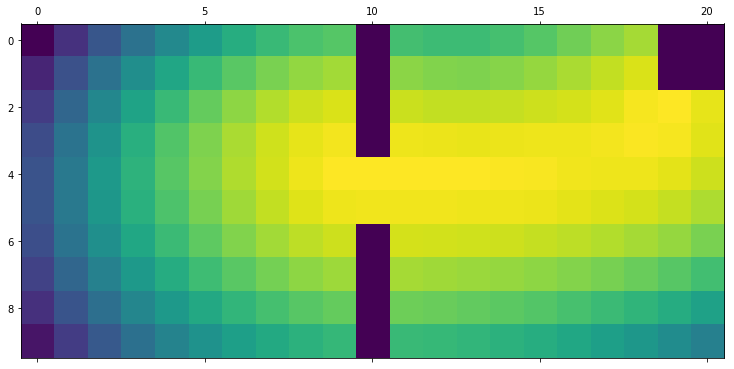

In [51]:
plt.matshow(DD_map/100,vmin=np.min(DD_map/100), vmax=0)
plt.show()